In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Attention, LayerNormalization, Dropout

## Load the IMDB Dataset





In [16]:
df = pd.read_csv("/content/IMDB Dataset.csv")

## Data Preprocessing


In [17]:
df['cleaned_review'] = df['review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: x.lower())
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['sentiment'], test_size=0.2, random_state=42)

##Label Encoding for Sentiment Column




In [19]:
# Label Encoding for Sentiment Column
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

## Tokenization and Padding


In [20]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=100, truncating='post', padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=100, truncating='post', padding='post')

##Transformer-Based Model Building



In [21]:
# Transformer Model Building
embedding_dim = 32  # We can Adjust the embedding dimension based on our preference
num_heads = 2
ff_dim = 32

inputs = Input(shape=(100,))
embedding_layer = Embedding(input_dim=10000, output_dim=embedding_dim)(inputs)
transformer_block = embedding_layer

for _ in range(num_heads):
    attn_output = Attention(use_scale=True)([transformer_block, transformer_block])
    transformer_block = LayerNormalization(epsilon=1e-6)(transformer_block + attn_output)
    transformer_block = Dropout(0.1)(transformer_block)

transformer_block = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(transformer_block)
transformer_block = tf.keras.layers.GlobalAveragePooling1D()(transformer_block)
transformer_block = Dropout(0.1)(transformer_block)
transformer_block = Dense(20, activation='relu')(transformer_block)
output_layer = Dense(1, activation='sigmoid')(transformer_block)

model = Model(inputs=inputs, outputs=output_layer)

## Model Training


In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7591 - loss: 0.4786 - val_accuracy: 0.8642 - val_loss: 0.3193
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8914 - loss: 0.2664 - val_accuracy: 0.8644 - val_loss: 0.3194
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9133 - loss: 0.2170 - val_accuracy: 0.8640 - val_loss: 0.3301
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9254 - loss: 0.1913 - val_accuracy: 0.8596 - val_loss: 0.3684
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9332 - loss: 0.1680 - val_accuracy: 0.8559 - val_loss: 0.3712


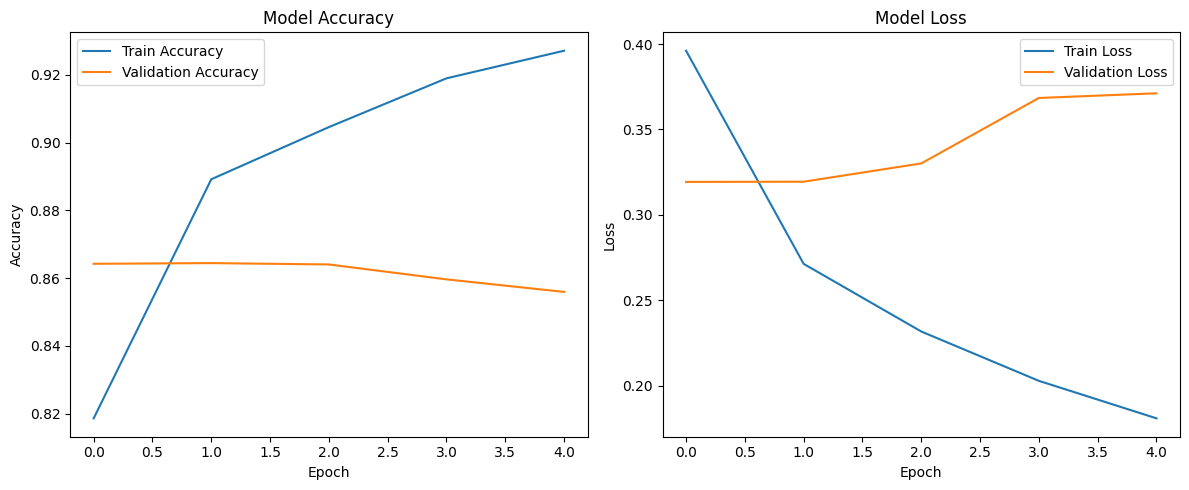

In [23]:

# Train the model and save the history
history = model.fit(
    X_train_padded,
    y_train_encoded,
    epochs=5,
    validation_data=(X_test_padded, y_test_encoded)
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


##Save the Model




In [24]:
model.save('/content/transformer_sentiment_model.h5')

## Evaluate the Model



In [25]:
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

# Converting back to original labels
y_pred_original = label_encoder.inverse_transform(y_pred.flatten())

print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("Classification Report:\n", classification_report(y_test_encoded, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.8559
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      4961
           1       0.86      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## User Input Prediction



In [26]:
# User Input Prediction
def predict_sentiment_transformer(review):
    cleaned_review = re.sub(r'[^a-zA-Z\s]', '', review.lower())
    cleaned_review = ' '.join(word for word in cleaned_review.split() if word not in stop_words)
    sequence = tokenizer.texts_to_sequences([cleaned_review])
    padded_sequence = pad_sequences(sequence, maxlen=100, truncating='post', padding='post')
    prediction = model.predict(padded_sequence)
    if 0.4 <= prediction <= 0.55:
        return "Neutral"
    elif prediction > 0.55:
        return "Positive"
    else:
        return "Negative"



In [27]:
# Enter your review to get the prediction of the sentiment
user_input = input("Enter your Review here: ")
prediction = predict_sentiment_transformer(user_input)
print(f"Predicted Sentiment: {prediction}")

Enter your Review here: I love the way Actor Fight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Predicted Sentiment: Positive
